# 设计思路
1. 使用周期性定时器AP Timer4.
2. 设计不同周期作为测试用例：1300、2600、26000、260000、2600000.
3. 根据周期性定时器特性，在ISR中读取当前计数，即可知从中断触发到ISR之间耗时。

# 内核实现

1. 创建/proc/interrupt_stats节点
2. echo 0...4 > /porc/interrupt_stats设置不同周期
3. cat /proc/interrupt_stats > interrupts_xxxx.txt获取测试结果

# 分析测试结果

原始数据类型：

2600000, 321, 3277

2600000, 334, 3277

2600000, 315, 3277

2600000, 321, 3277

2600000, 324, 3277


列分别是：周期Cycles(26M)，中断耗时Cycles(26M)，32768计时的周期耗时。

下面的分析只需要关注第二列，即从中断触发到ISR开始的耗时。
结果分两部分：
1. 每种周期1024次图表，可以对此周期中断耗时有大概印象。
2. 每种周期的统计信息。


In [6]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

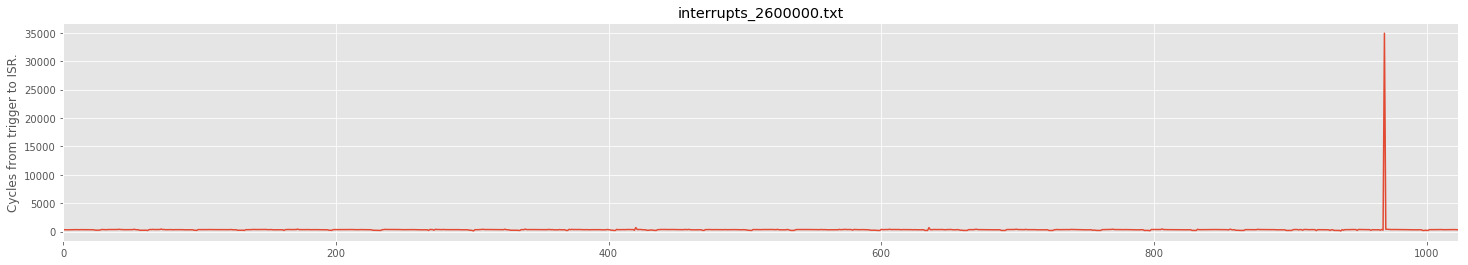

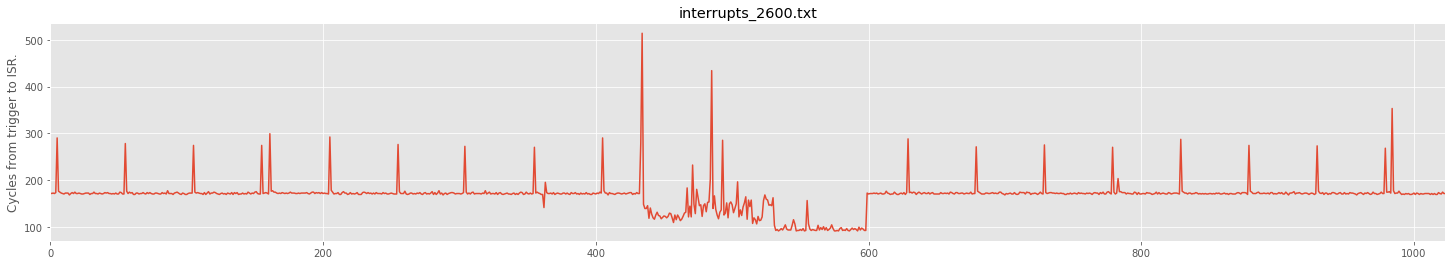

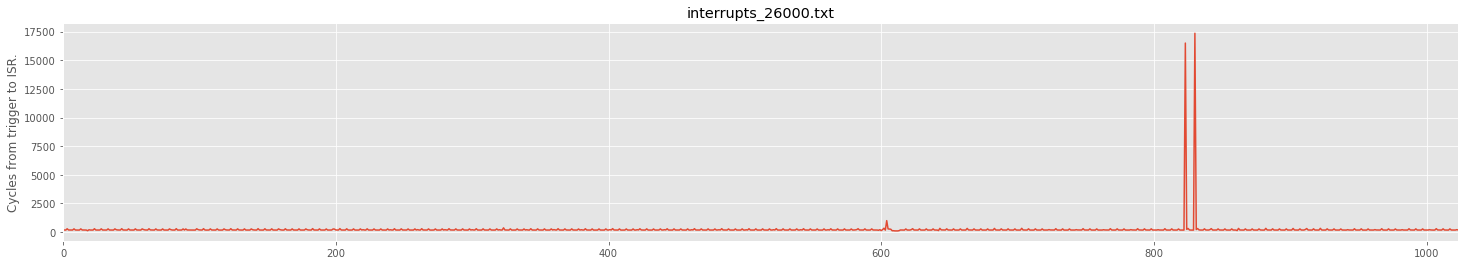

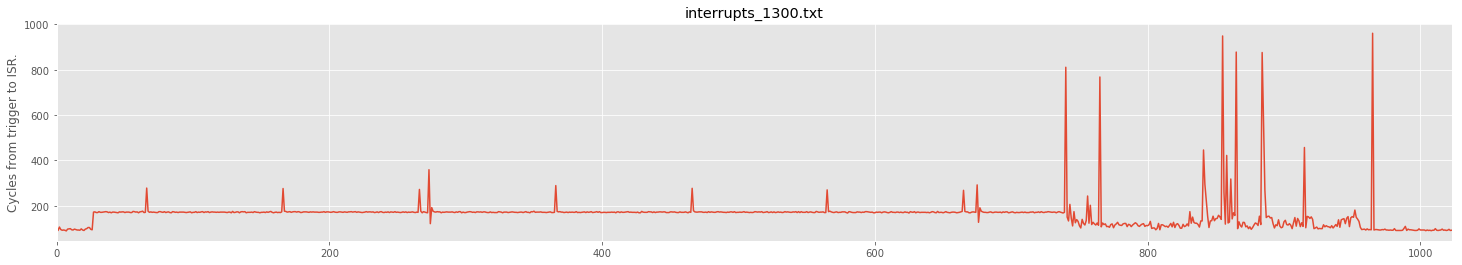

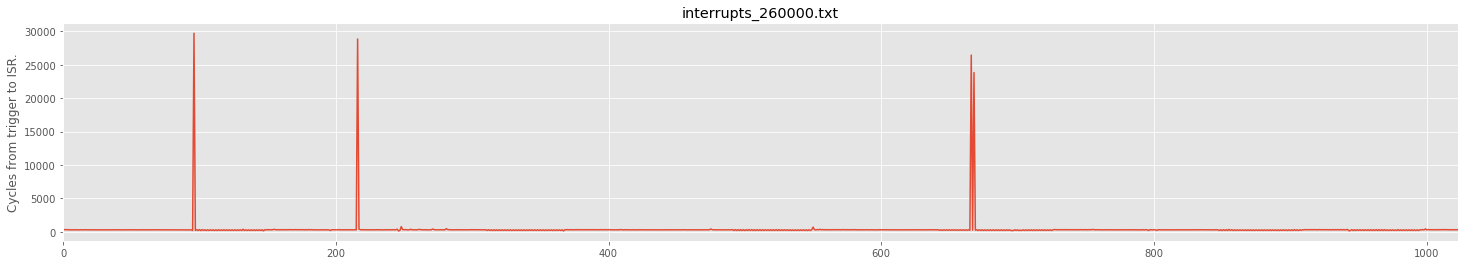

          mean(us)      max(us)   min(us)    std(us)
1300     13.993164  1342.576923  4.692308  41.583320
2600      6.389573    19.769231  3.500000   1.187153
26000     8.779334   667.576923  3.730769  28.486510
260000    6.223821    36.961538  3.423077   2.570918
2600000  15.475849  1142.192308  5.615385  64.794017


,max(us),min(us),std(us)
mean(us),,,
6.223821,36.961538,3.423077,2.570918
6.389573,19.769231,3.500000,1.187153
8.779334,667.576923,3.730769,28.486510
13.993164,1342.576923,4.692308,41.583320
15.475849,1142.192308,5.615385,64.794017


In [7]:
cnames = ['index', 'count', 'duration']

output = []
output_cycles = []

timer_freq = 26000000
p = re.compile('^interrupts_([0-9]*).txt$')

filenames = os.listdir('.')
for file in filenames:
    if p.match(file):
        data = []
        interrupt_data = []
        interrupt_stats = []

        duration_data = []

        interrupt_stats = pd.read_csv(file, names = cnames)
        
        #Show the plotting of interrupts time consumption
        ts = pd.Series(interrupt_stats['count'], index=range(len(interrupt_stats['count'])))
        #ts.plot(title='%s'%file, ylim=(0, 500))
        ts.plot(title='%s'%file)
        fig = plt.gcf()
        fig.set_size_inches(25, 4)
        plt.ylabel('Cycles from trigger to ISR.')
        plt.show()
        
        #Convert to time consumption
        for i in interrupt_stats['count'].tolist():
            data.append(float(i)*1000000/timer_freq)

        #Calc the timer duration
        for i in interrupt_stats['duration'].tolist():
            duration_data.append(i)

        #Statistics of interrupts
        interrupt_data = np.array(data)
        output.append([interrupt_data.mean(), interrupt_data.max(), interrupt_data.min(), interrupt_data.std()])
        output_cycles.append([interrupt_stats['count'].mean(),
                              interrupt_stats['count'].max(),
                              interrupt_stats['count'].min(),
                              interrupt_stats['count'].std()])
        
df = pd.DataFrame(output, columns=['mean(us)','max(us)','min(us)', 'std(us)'], index=['1300', '2600', '26000', '260000', '2600000'])
#df.to_csv('interrupt.csv')
print df
pd.pivot_table(df, index='mean(us)')

In [8]:
df2 = pd.DataFrame(output_cycles, columns=['mean(cycles)','max(cycles)','min(cycles)', 'std(cycles)'], index=['1300', '2600', '26000', '260000', '2600000'])
pd.pivot_table(df2, index='mean(cycles)')

,max(cycles),min(cycles),std(cycles)
mean(cycles),,,
161.819336,961,89,66.876534
166.128906,514,91,30.881051
228.262695,17357,97,741.011177
363.822266,34907,122,1081.694607
402.372070,29697,146,1685.467617
